In [1]:
import SiemensQuadraProperties as sqp
import ExplorerProperties as ep
from ActivityTools import *

In [2]:
from SimulationDataset import *
import matplotlib.pyplot as mpl

In [3]:
# the activity calculation is usually quoted divided by the TOTAL PHANTOM VOLUME
# explorer paper says 22L for 70cm phantom, I say 22.64
# so 1e9 Bq == 44kBq/cc (or ml, since cc==ml)
# from the explorer plots, 16 kBq/cc == 0.36e9 Bq

363801.0 events loaded (1000000 simulated) with average 1.1635399572843395 hits/event
107165.0 events loaded (1000000 simulated) with average 1.0078010544487472 hits/event
8411 3343 5068
9421 3797 5624
10231 4299 5932
10584 4687 5897
11080 5072 6008
11261 5312 5949
11357 5526 5831
11272 5667 5605
10869 5694 5175
10574 5788 4786
9873 5505 4368
9468 5358 4110
8964 5204 3760
8232 4904 3328
7484 4586 2898
7093 4360 2733
6490 4138 2352
5706 3673 2033
5282 3421 1861
4679 3067 1612
4379 2885 1494
3918 2579 1339
3506 2324 1182
3268 2241 1027
2874 1932 942
2452 1702 750
2207 1519 688
1988 1376 612
1756 1241 515
1624 1124 500
1436 1010 426
1192 823 369
1125 805 320
1020 724 296
871 598 273
396061.0 events loaded (1000000 simulated) with average 1.1579201183656054 hits/event
235404.0 events loaded (1000000 simulated) with average 1.0007476508470545 hits/event
6960 2644 4316
7904 3191 4713
8459 3463 4996
9009 3945 5064
9457 4223 5234
9640 4325 5315
9750 4670 5080
9593 4826 4767
9225 4750 4475
8948

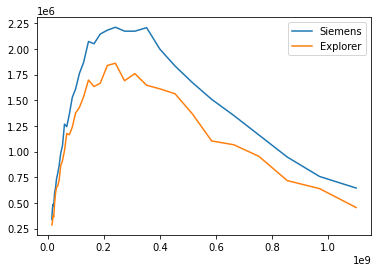

In [4]:
# Include background
def NECRatTimeBetterWithZ( tracerData, crystalData, crystalActivity, detectorRadius, simulationWindow=1E-2, coincidenceWindow=4.7E-9, zWindow=325.0 ):
    
    necrAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        necr = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        activityAtTime.append( activity )
    
    return activityAtTime, necrAtTime

labels = [ "Siemens", "Explorer" ]
tracerData = CreateDataset( 1024, "Siemens", "LinearF18", 1000000, 435.0, 585.0 )
crystalData = CreateDataset( 1024, "Siemens", "Siemens", 1000000, 435.0, 585.0 )
activityAtTime, necrAtTime = NECRatTimeBetterWithZ( tracerData, crystalData, sqp.Lu176decaysInMass( sqp.DetectorMass() ), sqp.DetectorRadius() )
mpl.plot( activityAtTime, necrAtTime, label=labels[0] )

tracerData = CreateDataset( 1850, "Explorer", "LinearF18", 1000000, 430.0, 645.0 )
crystalData = CreateDataset( 1850, "Explorer", "Explorer", 1000000, 430.0, 645.0 )
activityAtTime, necrAtTime = NECRatTimeBetterWithZ( tracerData, crystalData, ep.Lu176decaysInMass( ep.DetectorMass() ), ep.DetectorRadius(), coincidenceWindow=4.5E-9 )
mpl.plot( activityAtTime, necrAtTime, label=labels[1] )

mpl.legend( labels )
mpl.show()

In [5]:
# Debug information about the background
print( "Siemens Quadra mass :", sqp.DetectorMass() )
print( "Siemens Quadra background (Bq) :", sqp.Lu176decaysInMass( sqp.DetectorMass() ) )
print( "Explorer mass :", ep.DetectorMass() )
print( "Explorer background (Bq) :", ep.Lu176decaysInMass( ep.DetectorMass() ) )

Siemens Quadra mass : 368574.46400000004
Siemens Quadra background (Bq) : 14726005.989989998
Explorer mass : 552590.79579648
Explorer background (Bq) : 20646468.60786598
